# Rossmann Store Sales Forecast Using Deep Learning

![Rossmann](images/photo.png)

The objective of this notebook is to forecast sales using store, promotion, and competitor data using deep neural network and explain the process to the C-Suite inin layman's terms. The data was obtained from [Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data).

This notebook is available at https://git.io/v53iN.

## Introduction

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

The objective of this project is to predict daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By creating a robust prediction model, store managers can stay focused on their customers and their teams.

The developed model achieved high accuracy with Root Mean Squared Percentage Error (RMSPE) 0.217. The formula is:

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

where:

- $\hat{y}_i$ is the actual sales of one store on a particular day
- $y_i$ is the corresponding sales predicted by the model
- $n$ is the number of predictions made

Below is a high-level overview of the steps taken to develop such robust model:
1. Transform the raw data into format which is accepted by the machine learning algorithm.
2. Build a predictive model by feeding the transformed data to the algorithm.
3. Use a seperate set of raw data to evaluate the performnace of the derived model.

In particular, the model we uses is deep nerual network, which is also called deep learning and is the underlying model of cutting-edge applications like Siri and AlphaGo. A simplified illustration of an nerual network:

![a simplified illustration of neural network](images/neural_network.png)

## Setup the environment

Import the modules to be used by this notebook:

In [103]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
from keras.utils.visualize_util import plot, model_to_dot
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
from utils2 import *
from isoweek import Week
from pandas_summary import DataFrameSummary
from IPython.display import SVG

Set the preferred options:

In [2]:
np.set_printoptions(threshold=50, edgeitems=20)
%matplotlib inline
%cd data/

/home/ubuntu/rossmann/data


## Import dataset

The following tables are available in the datasets:

| Table        | Table Description                                                                                               |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| train        | training set: store information on a daily basis, tracking things like sales, customers, whether that day was a holiday, etc. |
| store        | general information about the store including competition, etc.                                                 |
| store_states | maps store to state it is in                                                                                    |
| state_names  | maps state abbreviations to names                                                                               |
| googletrend  | trend data for particular week/state                                                                            |
| weather      | weather conditions for each state                                                                               |

Import the tables to the environemnts:

In [3]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, store, store_states, state_names, googletrend, weather = [pd.read_csv(fname+'.csv', low_memory=False) for fname in table_names]

Display the first 5 rows and statsitics of each table to get a quick understanding of the dataset:

In [4]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


In [5]:
display(store.head())
display(DataFrameSummary(store).summary())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


In [6]:
display(store_states.head())
display(DataFrameSummary(store_states).summary())

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


In [7]:
display(state_names.head())
display(DataFrameSummary(state_names).summary())

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,StateName,State
count,16,16
unique,16,16
top,Niedersachsen,HE
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [8]:
display(googletrend.head())
display(DataFrameSummary(googletrend).summary())

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


In [9]:
display(weather.head())
display(DataFrameSummary(weather).summary())

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- `Customers`: the number of customers on a given day
- `Open`: an indicator for whether the store was open: 0 = closed, 1 = open
- `StateHoliday`: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- `SchoolHoliday`: indicates if the (Store, Date) was affected by the closure of public schools
- `StoreType`: differentiates between 4 different store models: a, b, c, d
- `Assortment`: describes an assortment level: a = basic, b = extra, c = extended
- `CompetitionDistance`: distance in meters to the nearest competitor store
- `CompetitionOpenSince[Month/Year]`: gives the approximate year and month of the time the nearest competitor was opened
- `Promo`: indicates whether a store is running a promo on that day
- `Promo2`: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- `Promo2Since[Year/Week]`: describes the year and calendar week when the store started participating in Promo2
- `PromoInterval`: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## Data Cleaning / Feature Engineering


Data cleaning is the process of transforming the data into formats that the model can understand.

Feature engineering is the process of using domain knowledge of the data to create features (columns) that make machine learning algorithms work. More meaningful features (field) make it easier to "learn". For example, we will create a field / column called "CompetitionOpenSince" and "CompetitionDaysOpen" using raw columns.

Turn state Holidays to Boolean:

In [10]:
train.StateHoliday = train.StateHoliday!='0'

Join weather/state names into a single table.

In [11]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))
weather = join_df(weather, state_names, "file", "StateName")

Extracting dates and state names from the given data and adding those columns.

Replace all instances of state name 'NI' with the usage in the rest of the table, 'HB,NI'.

In [12]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.
Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.
We'll add to every table w/ a date field.

In [13]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)

In [14]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe.

In [15]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [16]:
joined = join_df(train, store, "Store")
len(joined[joined.StoreType.isnull()])

0

In [17]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()])

0

In [18]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()])

0

In [19]:
joined = join_df(joined, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()])

0

Next we'll fill in missing values to avoid complications w/ na's.

In [20]:
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [21]:
joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1).astype(pd.datetime))
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

We'll replace some erroneous / outlying data.

In [22]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Added "CompetitionMonthsOpen" field, limit the maximum to 2 years to limit number of unique embeddings.

In [23]:
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"]//30
joined.loc[joined.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [24]:
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

In [25]:
joined.loc[joined.Promo2Days<0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear<1990, "Promo2Days"] = 0

In [26]:
joined["Promo2Weeks"] = joined["Promo2Days"]//7
joined.loc[joined.Promo2Weeks<0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks>25, "Promo2Weeks"] = 25
joined.Promo2Weeks.unique()

array([ 0, 25, 17,  8, 13, 24, 16,  7, 12, 23, 15,  6, 11, 22, 14,  5, 10,
       21,  4,  9, 20,  3, 19,  2, 18,  1])

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

In [27]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

We've defined a class `elapsed` for cumulative counting across a sorted dataframe.

Given a particular field `fld` to monitor, this object will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen.

In [28]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [29]:
df = train[columns]

And a function for applying said class across dataframe rows and adding values to a new column.

In [30]:
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will generate an instance of the `elapsed` class for School Holiday:
* Instance applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another promotion.

In [31]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

We'll do this for two more fields.

In [32]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [33]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [34]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [35]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [36]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [37]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [38]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [39]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [40]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [41]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [42]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [43]:
df.drop(columns,1,inplace=True)

In [44]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [45]:
df.to_csv('df.csv')

In [46]:
df = pd.read_csv('df.csv', index_col=0)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [47]:
df["Date"] = pd.to_datetime(df.Date)

In [48]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [49]:
joined = join_df(joined, df, ['Store', 'Date'])

We'll back this up as well.

In [50]:
joined.to_csv('joined.csv')

We now have our final set of engineered features.

In [51]:
joined = pd.read_csv('joined.csv', index_col=0)
joined["Date"] = pd.to_datetime(joined.Date)
joined.columns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE',
       'trend_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [52]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

This dictionary maps categories to embedding dimensionality. In generally, categories we might expect to be conceptually more complex have larger dimension.

In [53]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

Name categorical variables

In [54]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

Likewise for continuous

In [55]:
# mean/max wind; min temp; cloud; min/mean humid; 
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Replace nulls w/ 0 for continuous, "" for categorical.

In [56]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

Here we create a list of tuples, each containing a variable and an instance of a transformer for that variable.

For categoricals, we use a label encoder that maps categories to continuous integers. For continuous variables, we standardize them.

In [57]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

The same instances need to be used for the test set as well, so values are mapped/standardized appropriately.

DataFrame mapper will keep track of these variable-instance mappings.

In [58]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [59]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


16

Example of first five rows of zeroth column being transformed appropriately.

In [60]:
cat_map_fit.transform(joined)[0,:5], contin_map_fit.transform(joined)[0,:5]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(array([ 0, 30,  4,  6,  4]),
 array([-0.53772351,  1.02444552,  0.81863226,  0.32504749,  0.61112004]))

We can also pickle these mappings, which is great for portability!

In [61]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [62]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

## Sample data

Next, the authors removed all instances where the store had zero sale / was closed.

In [63]:
joined_sales = joined[joined.Sales!=0]
n = len(joined_sales)

We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little EDA reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. Be ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [64]:
n

844338

We're going to run on a sample.

In [65]:
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [66]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [67]:
samp_size = n
joined_samp = joined_sales.set_index("Date")

In time series data, cross-validation is not random. Instead, our holdout data is always the most recent data, as it would be in real application.

We've taken the last 10% as our validation set.

In [68]:
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

In [69]:
train_size

759904

In [70]:
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

Here's a preprocessor for our categoricals using our instance mapper.

In [71]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [72]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

Same for continuous.

In [73]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [74]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Grab our targets.

In [75]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

Finally, the authors modified the target values by applying a logarithmic transformation and normalizing to unit scale by dividing by the maximum log value.

Log transformations are used on this type of data frequently to attain a nicer shape. 

Further by scaling to the unit interval we can now use a sigmoid output in our neural network. Then we can multiply by the maximum log value to get the original log value and transform back.

In [76]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

Note: Some testing shows this doesn't make a big difference.

Root-mean-squared percent error is the metric Kaggle used for this competition.

These undo the target transformations.

## Create models

Now we're ready to put together our models.

In [77]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [78]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

Helper function for getting categorical name and dim.

In [79]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

For example the dimension of the feature `Day` is 31: 

In [80]:
cat_map_info(cat_map_fit.features[1])

('Day', 31)

In [81]:
def my_init(scale):
    return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)

In [82]:
def emb_init(shape, name=None): 
    return initializations.uniform(shape, scale=2/(shape[1]+1), name=name)

Helper function for constructing embeddings.

Also, note we're flattening the embedding. Embeddings in Keras come out as an element of a sequence like we might use in a sequence of words; here we just want to concatenate them so we flatten the 1-vector sequence into a vector.

In [83]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
    return inp,u

Helper function for continuous inputs.

In [84]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

Let's build them.

In [85]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

Now we can put them together. Given the inputs, continuous and categorical embeddings, we're going to concatenate all of them.

Next, we're going to pass through some dropout, then two dense layers w/ ReLU activations, then dropout again, then the sigmoid activation we mentioned earlier.

In [86]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [87]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', init='uniform')(x)
x = Dense(500, activation='relu', init='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
# model.compile(optimizer = "adam", loss = 'mean_squared_error')
model.compile(optimizer = "adam", loss = 'mean_absolute_error')

## Start training

In [88]:
hist = model.fit(map_train, y_train, batch_size=128, nb_epoch=25,
                 verbose=1, validation_data=(map_valid, y_valid))

Train on 759904 samples, validate on 84434 samples
Epoch 1/25
759904/759904 [==============================] - 101s - loss: 0.0116 - val_loss: 0.0121
Epoch 2/25
759904/759904 [==============================] - 101s - loss: 0.0082 - val_loss: 0.0104
Epoch 3/25
759904/759904 [==============================] - 101s - loss: 0.0072 - val_loss: 0.0103
Epoch 4/25
759904/759904 [==============================] - 101s - loss: 0.0068 - val_loss: 0.0099
Epoch 5/25
759904/759904 [==============================] - 101s - loss: 0.0066 - val_loss: 0.0097
Epoch 6/25
759904/759904 [==============================] - 101s - loss: 0.0064 - val_loss: 0.0098
Epoch 7/25
759904/759904 [==============================] - 101s - loss: 0.0063 - val_loss: 0.0098
Epoch 8/25
759904/759904 [==============================] - 101s - loss: 0.0063 - val_loss: 0.0095
Epoch 9/25
759904/759904 [==============================] - 101s - loss: 0.0062 - val_loss: 0.0096
Epoch 10/25
759904/759904 [==============================]

In [89]:
hist.history

{'loss': [0.011566536738518231,
  0.0081653625413307326,
  0.0071860848924713535,
  0.006774629578635962,
  0.0065704475156335377,
  0.0064391641854727203,
  0.0063273430748473176,
  0.0062555727449203746,
  0.0061891611395114704,
  0.0061404826117777284,
  0.0061077357682363335,
  0.0060801989862342134,
  0.0060346056350902991,
  0.0060051636216288144,
  0.0059794262842424112,
  0.0059676757661993067,
  0.0059432794634721366,
  0.0059252565913867133,
  0.0059148652881081754,
  0.005895444187482151,
  0.0058807758053595824,
  0.0058667969493008025,
  0.0058551509982480016,
  0.0058396470268404152,
  0.0058420273531941298],
 'val_loss': [0.012086203907870284,
  0.010352625027604243,
  0.010253162543005512,
  0.0099490500198491476,
  0.0097175058172275144,
  0.0097798881480276999,
  0.0097666648750737405,
  0.0095192645254970707,
  0.0096451207526808379,
  0.0096954195753682672,
  0.0094691298552245558,
  0.009646143594679378,
  0.0096971910569714371,
  0.0093944105374057594,
  0.0095333

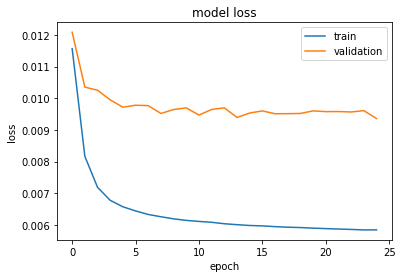

In [90]:
plot_train(hist)

In [91]:
preds = np.squeeze(model.predict(map_valid, 1024, verbose=1))

78848/84434 [===========================>..] - ETA: 0s

In [92]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

In [93]:
print(log_max_inv(preds, max_log_y)[0])
print(log_max_inv(y_valid, max_log_y)[0])
print(math.sqrt(np.square(((log_max_inv(preds, max_log_y)[0] - log_max_inv(y_valid, max_log_y)[0])/log_max_inv(y_valid, max_log_y)[0]).mean())))

7121.25
7956.0
0.10492032349798854


In [94]:
preds_log_max_inv = log_max_inv(preds, max_log_y)
print(preds_log_max_inv)

[  7121.25390625   9269.30175781   4955.69238281   6846.35351562
   5676.14550781   5387.85058594   6442.00195312   7486.08447266
   5283.67529297   6420.36962891   9710.92089844   7194.63671875
   6568.11914062   4992.50341797   6830.98144531   5716.58496094
   8411.59082031   5036.11474609   3378.15136719   5894.16894531 ...,
   5794.19482422  20665.859375     4309.36767578   5193.98193359
   8032.84375     23000.01367188   2676.85375977   4778.50390625
   4009.45483398   7885.83300781   4860.13720703   3802.7644043    3655.5625
  16097.47265625   4839.35253906   5054.62548828  12570.34179688
   6470.92919922   4729.20117188   6024.04394531]


In [95]:
y_valid_array =  log_max_inv(np.array(y_valid), max_log_y)
print(y_valid_array)

[  7956.   8958.   4676.   6913.   6157.   5010.   6723.   8033.   5196.
   6413.  10012.   6619.   6806.   4765.   6973.   5080.  11710.   5088.
   3612.   6362. ...,   6218.  20642.   3697.   4220.   6851.  17267.
   3102.   2401.   3139.   9643.   3113.   2646.   2907.   8498.   3821.
   3375.  10765.   5035.   4491.   5961.]


In [120]:
print(sqrt(square((preds_log_max_inv - y_valid_array)/y_valid_array)))

[ 0.10492032  0.03475126  0.05981445  0.00964075  0.07809883  0.07541928
  0.04179653  0.0680836   0.01687361  0.00114917  0.03007182  0.08696732
  0.03495164  0.04774468  0.02036692  0.125312    0.28167457  0.01019757
  0.06474215  0.07353522 ...,  0.0681578   0.00115587  0.16563908
  0.23080141  0.17250675  0.33202141  0.13705553  0.99021404  0.27730323
  0.18222203  0.56123906  0.43717476  0.25750344  0.89426602  0.26651467
  0.49766681  0.16770477  0.28518951  0.05303967  0.01057607]


In [115]:
from numpy import mean, sqrt, square, arange
print(sqrt(mean(square((preds_log_max_inv - y_valid_array)/y_valid_array))))

0.216830510127
